In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [2]:
v = pd.read_csv('/home/mimimustaine/Downloads/Análisis_de_datos/da2019-MIMIMUSTAINE/Semana14/Trabajo/NOAO_Data_Lab/result_7', encoding = "ISO-8859-1", engine='python')
v.head()

allmask_g  allmask_r  allmask_z  anymask_g  anymask_r  anymask_z  brickid  \
0          0          0          0          0          0          0   475175   
1          0          0          0          0          0          0   475175   
2          0          0          0          0          0          0   475175   
3          0          0          0          0          0          0   475175   
4          0          0          0          0          0          0   475175   

  brickname  brick_primary  brightstarinblob  ...    snr_w4     snr_z  type  \
0  3299p257              1                 0  ... -0.203402  12.13880   PSF   
1  3299p257              1                 0  ...  2.164960   8.06203   PSF   
2  3299p257              1                 0  ... -2.258560  16.66540   PSF   
3  3299p257              1                 0  ... -4.090530  35.12620   PSF   
4  3299p257              1                 0  ...  0.048777   6.16678   REX   

     w1_w2    w2_w3    w3_w4  wise_coadd_id  wisemask_w1  wisemask_w2     z_w1  
0 -1.37254      NaN      NaN       3300p257            0            0  1.08618  
1      NaN      NaN  4.71022       3300p257            0            0      NaN  
2      NaN      NaN      NaN       3300p257            0            0      NaN  
3      NaN  5.56772      NaN       3300p257            0            0      NaN  
4      NaN      NaN  0.62468       3300p257            0            0      NaN  

[5 rows x 182 columns]

### <strong>Tipo de estrellas</strong>

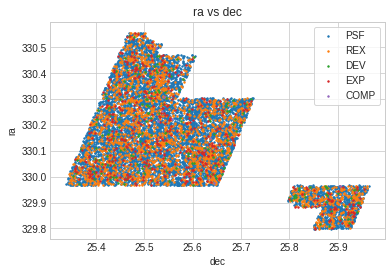

In [3]:
#Tipos de estrellas
tipos = v['type'].unique()

for i in range(len(tipos)):
    plt.scatter(v['dec'][v['type'] == tipos[i]], v['ra'][v['type'] == tipos[i]], s = 2.0, label = '{}'.format(tipos[i]))
plt.title('ra vs dec')
plt.xlabel('dec')
plt.ylabel('ra')
plt.legend(frameon = True, loc = 'best')
plt.show()

### <strong>Transformación</strong>

In [4]:
#Primero hay que transformar de grados a radianes:
def ang(angulo):
    return (angulo * np.pi) / 180

In [5]:
#Argumentos de ángulos en grados (como se observan en la gráfica).
def Random(N, lix, lsx, liy, lsy):
    #Generación de ángulos random
    cos_decr = []

    for i in range(N):
        cos_decr.append(np.random.uniform(np.cos(ang(lix)), np.cos(ang(lsx)))) #para dec

    #Generación de puntos random en coordenadas cartesianas:
    x_r, y_r, z_r = [], [], []
    
    for i in range(N):
        ra_r = np.random.uniform(ang(liy), ang(lsy))
        x_r.append(np.cos(ra_r) * np.sqrt(1 - cos_decr[i] ** 2))
        y_r.append(np.sin(ra_r) * np.sqrt(1 - cos_decr[i] ** 2))
        z_r.append(cos_decr[i])

    return x_r, y_r, z_r

In [6]:
def proyeccion(obs, ran):
    fig = plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.scatter(obs[:,0], obs[:,1], alpha = 0.6, s = 0.5, color = 'red')
    plt.scatter(ran[:,0], ran[:,1], alpha = 0.5, s = 0.5, color = 'purple')
    plt.title('Proyección xy')
    plt.xlabel('x')
    plt.ylabel('y')
    
    plt.subplot(1, 3, 2)
    plt.scatter(obs[:,0], ran[:,2], alpha = 0.6, s = 0.5, color = 'red')
    plt.scatter(obs[:,0], ran[:,2], alpha = 0.5, s = 0.5, color = 'purple')
    plt.title('Proyección xz')
    plt.xlabel('x')
    plt.ylabel('z')
    
    plt.subplot(1, 3, 3)
    plt.scatter(obs[:,1], ran[:,2], alpha = 0.6, s = 0.5, color = 'red')
    plt.scatter(obs[:,1], ran[:,2], alpha = 0.5, s = 0.5, color = 'purple')
    plt.title('Proyección yz')
    plt.xlabel('y')
    plt.ylabel('z')
    plt.show()
    
#Hecha para un único v:

def transformacion(N):
    #Generación de ángulos random
    cos_decr = []

    for i in range(N):
        cos_decr.append(np.random.uniform(np.cos(ang(25.3)), np.cos(ang(25.7)))) #para dec

    #Generación de puntos random en coordenadas cartesianas:
    x_r, y_r, z_r = [], [], []
    for i in range(N):
        if v['dec'][i] < 25.7:
            ra_r = np.random.uniform(ang(329.95), ang(330.55))
            x_r.append(np.cos(ra_r) * np.sqrt(1 - cos_decr[i] ** 2))
            y_r.append(np.sin(ra_r) * np.sqrt(1 - cos_decr[i] ** 2))
            z_r.append(cos_decr[i])
    
    #Tranformación de los ángulos en datos a coordenadas cartesianas:
    x_o, y_o, z_o = [], [], []
    for i in range(N):
        if v['dec'][i] < 25.7:
            x_o.append(np.cos(ang(v['ra'][i])) * np.sin(ang(v['dec'][i])))
            y_o.append(np.sin(ang(v['ra'][i])) * np.sin(ang(v['dec'][i])))
            z_o.append(np.cos(ang(v['dec'][i])))
        
    proyeccion(np.array([x_o, y_o, z_o]).T, np.array([x_r, y_r, z_r]).T)
    
    return np.array([x_o, y_o, z_o]).T, np.array([x_r, y_r, z_r]).T

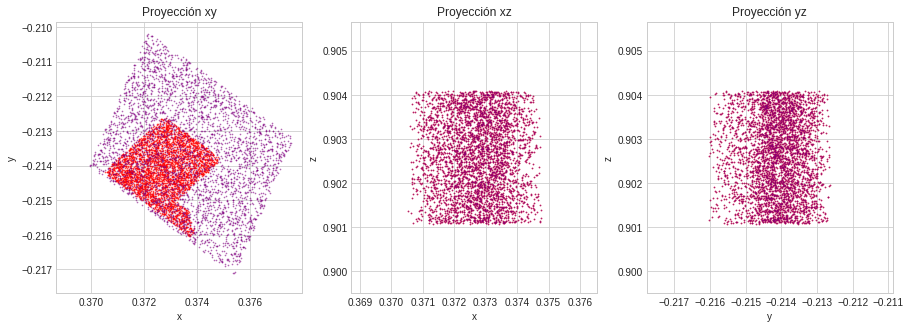

In [7]:
obs, ran = transformacion(5000)

### <strong>Algoritmo para la función de correlación</strong>

In [8]:
#Función de distancia entre dos puntos en R^3:
def distance(v1, v2):
    return np.sqrt((v1[0] - v2[0]) ** 2 + (v1[1] - v2[1]) ** 2 + (v1[2] - v2[2]) ** 2)

#Función para combinaciones de los elementos del mismo arreglo:
def f1(v, N):
    a = [] #auxiliar
    for i in range(N):
        for j in range(N):
            if j > i:
                a.append(distance(v[i], v[j]))
    return np.array(a)

#Función para combinaciones de los elementos de dos arreglos:
def f2(v1, v2, N1, N2):
    a = [] #auxiliar
    for i in range(N1):
        for j in range(N2):
                a.append(distance(v1[i], v2[j]))
    return np.array(a)

#Función de correlación Peebles & Hauser:
def PH(obs, ran, bines):
    #Los resultados por cada bin se guardarán en arreglo:
    result = []
    
    #Distancias entre observado-observado, observado-random, random-random:
    OO, RR = f1(obs, len(obs)), f1(ran, len(ran))
    
    #Factores de normalización:
    nOO, nRR = (len(obs)*(len(obs)-1)*0.5), (len(ran)*(len(ran)-1)*0.5)
    
    #Bines:
    OOb, RRb = np.linspace(0, np.max(OO), bines),  np.linspace(0, np.max(RR), bines)
    
    #Número de elementos en cada bin:
    for i in range(bines - 1):
        if i == (bines - 2):
            OON = len(OO[(OO >= OOb[i]) & (OO <= OOb[i + 1])])
            RRN = len(RR[(RR >= RRb[i]) & (RR <= RRb[i + 1])])
        else:
            OON = len(OO[(OO >= OOb[i]) & (OO < OOb[i + 1])])
            RRN = len(RR[(RR >= RRb[i]) & (RR < RRb[i + 1])])
        
        #El resultado de cada bin:
        result.append((nRR * OON / (nOO * RRN)) - 1)
        
    return OOb[: bines - 1], result

#Función de correlación Landy & Szalay:
def LS(obs, ran, bines):
    #Los resultados por cada bin se guardarán en arreglo:
    result = []
    
    #Distancias entre observado-observado, observado-random, random-random:
    OO, OR, RR = f1(obs, len(obs)), f2(obs, ran, len(obs), len(ran)), f1(ran, len(ran))
    
    #Factores de normalización:
    nOO, nOR, nRR = (len(obs)*(len(obs)-1)*0.5), (len(obs)*len(ran)), (len(ran)*(len(ran)-1)*0.5)
    
    #Bines:
    OOb, ORb, RRb = np.linspace(0, np.max(OO), bines),  np.linspace(0, np.max(OR), bines),  np.linspace(0, np.max(RR), bines)
    
    #Número de elementos en cada bin:
    for i in range(bines - 1):
        if i == (bines - 2):
            OON = len(OO[(OO >= OOb[i]) & (OO <= OOb[i + 1])])
            ORN = len(OR[(OR >= ORb[i]) & (OR <= ORb[i + 1])])
            RRN = len(RR[(RR >= RRb[i]) & (RR <= RRb[i + 1])])
        else:
            OON = len(OO[(OO >= OOb[i]) & (OO < OOb[i + 1])])
            ORN = len(OR[(OR >= ORb[i]) & (OR < ORb[i + 1])])
            RRN = len(RR[(RR >= RRb[i]) & (RR < RRb[i + 1])])
        
        #El resultado de cada bin:
        result.append(1 + (OON * nRR / (RRN * nOO)) - (2 * ORN * nRR / (nOR * RRN)))
        
    return OOb[: bines - 1], result

In [8]:
ejex, ejey = PH(obs, ran, 50)
ejex1, ejey1 = LS(obs, ran, 50)

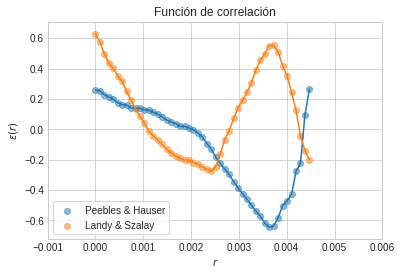

In [9]:
plt.scatter(ejex, ejey, alpha = 0.5, label = 'Peebles & Hauser')
plt.plot(ejex, ejey)
plt.scatter(ejex1, ejey1, alpha = 0.5, label = 'Landy & Szalay')
plt.plot(ejex1, ejey1)
plt.xlim(-0.001, 0.006)
plt.legend(frameon = True)
plt.xlabel('$r$')
plt.ylabel('$\\varepsilon (r)$')
plt.title('Función de correlación')
plt.show()

### <strong>Nueva definición de las funciones</strong>

Se nos pidió modificar la <strong>función de distancia</strong> para reducir el tiempo de ejecución del programa, por lo que a continuación se muestra el algoritmo modificado, se requieren dos diferentes funciones para el caso en el que se determinan distancias del mismo arreglo, entre dos diferentes arreglos.

In [9]:
def d1(u):
    dis = []
    n = 0
    for i in range(len(u)):
        M = np.linalg.norm(u[i] - u[n:], axis = 1)
        dis.extend(M[M!=0])
        n = n + 1
    return np.array(dis)

def d2(u, u_r):
    dis = []
    for i in range(len(u)):
        M = np.linalg.norm(u[i] - u_r, axis = 1)
        dis.extend(M)
    return np.array(dis)

Se implementan en las <strong>funciones de correlación:</strong>

In [10]:
#Función de correlación Peebles & Hauser:
def PH(obs, ran, bines):
    #Los resultados por cada bin se guardarán en arreglo:
    result = []
    
    #Distancias entre observado-observado, observado-random, random-random:
    OO, RR = d1(obs), d1(ran)
    
    #Factores de normalización:
    nOO, nRR = (len(obs)*(len(obs)-1)*0.5), (len(ran)*(len(ran)-1)*0.5)
    
    #Bines:
    OOb, RRb = np.linspace(0, np.max(OO), bines),  np.linspace(0, np.max(RR), bines)
    
    #Número de elementos en cada bin:
    for i in range(bines - 1):
        if i == (bines - 2):
            OON = len(OO[(OO >= OOb[i]) & (OO <= OOb[i + 1])])
            RRN = len(RR[(RR >= RRb[i]) & (RR <= RRb[i + 1])])
        else:
            OON = len(OO[(OO >= OOb[i]) & (OO < OOb[i + 1])])
            RRN = len(RR[(RR >= RRb[i]) & (RR < RRb[i + 1])])
        
        #El resultado de cada bin:
        result.append((nRR * OON / (nOO * RRN)) - 1)
        
    return OOb[: bines - 1], result

In [11]:
#Función de correlación Landy & Szalay:
def LS(obs, ran, bines):
    #Los resultados por cada bin se guardarán en arreglo:
    result = []
    
    #Distancias entre observado-observado, observado-random, random-random:
    OO, OR, RR = d1(obs), d2(obs, ran), d1(ran)
    
    #Factores de normalización:
    nOO, nOR, nRR = (len(obs)*(len(obs)-1)*0.5), (len(obs)*len(ran)), (len(ran)*(len(ran)-1)*0.5)
    
    #Bines:
    OOb, ORb, RRb = np.linspace(0, np.max(OO), bines),  np.linspace(0, np.max(OR), bines),  np.linspace(0, np.max(RR), bines)
    
    #Número de elementos en cada bin:
    for i in range(bines - 1):
        if i == (bines - 2):
            OON = len(OO[(OO >= OOb[i]) & (OO <= OOb[i + 1])])
            ORN = len(OR[(OR >= ORb[i]) & (OR <= ORb[i + 1])])
            RRN = len(RR[(RR >= RRb[i]) & (RR <= RRb[i + 1])])
        else:
            OON = len(OO[(OO >= OOb[i]) & (OO < OOb[i + 1])])
            ORN = len(OR[(OR >= ORb[i]) & (OR < ORb[i + 1])])
            RRN = len(RR[(RR >= RRb[i]) & (RR < RRb[i + 1])])
        
        #El resultado de cada bin:
        result.append(1 + (OON * nRR / (RRN * nOO)) - (2 * ORN * nRR / (nOR * RRN)))
        
    return OOb[: bines - 1], result

La función se utilizará para cada tipo de estrella que hay en los datos:

In [12]:
v['type'].unique()

array(['PSF', 'REX', 'DEV', 'EXP', 'COMP'], dtype=object)

In [13]:
#--------------------DATOS OBSERVADOS--------------------#
#Tranformación de los ángulos en datos a coordenadas cartesianas:
def Observados(N, vx, vy):
    x_o, y_o, z_o = [], [], []
    for i in range(N):
        x_o.append(np.cos(ang(vy[i])) * np.sin(ang(vx[i])))
        y_o.append(np.sin(ang(vy[i])) * np.sin(ang(vx[i])))
        z_o.append(np.cos(ang(vx[i])))
    return x_o, y_o, z_o

### <strong>PSF</strong>

In [14]:
PSF = v[v['type'] == 'PSF']

In [15]:
N = len(PSF)
x_o, y_o, z_o = Observados(N, np.array(PSF['dec']), np.array(PSF['ra']))
x_r, y_r, z_r = Random(N, 25.3, 25.7, 329.95, 330.5)

In [16]:
ex1, ey1 = PH(np.array([x_o, y_o, z_o]).T, np.array([x_r, y_r, z_r]).T, 50)
ex2, ey2 = LS(np.array([x_o, y_o, z_o]).T, np.array([x_r, y_r, z_r]).T, 50)

ex1, ey1, ex2, ey2 = np.array(ex1), np.array(ey1), np.array(ex2), np.array(ey2)

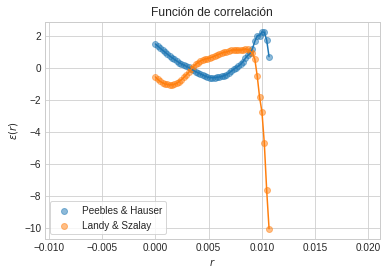

In [17]:
plt.scatter(ex1, ey1, alpha = 0.5, label = 'Peebles & Hauser')
plt.plot(ex1, ey1)
plt.scatter(ex2, ey2, alpha = 0.5, label = 'Landy & Szalay')
plt.plot(ex2, ey2)
#plt.xlim(-0.001, 0.006)
plt.legend(frameon = True, loc = 'best')
plt.xlabel('$r$')
plt.ylabel('$\\varepsilon (r)$')
plt.title('Función de correlación')
plt.show()

### <strong>REX</strong>

In [18]:
REX = v[v['type'] == 'REX']

In [19]:
N = len(REX)
x_o, y_o, z_o = Observados(N, np.array(REX['dec']), np.array(REX['ra']))
x_r, y_r, z_r = Random(N, 25.3, 25.7, 329.95, 330.5)

In [20]:
ex1, ey1 = PH(np.array([x_o, y_o, z_o]).T, np.array([x_r, y_r, z_r]).T, 50)
ex2, ey2 = LS(np.array([x_o, y_o, z_o]).T, np.array([x_r, y_r, z_r]).T, 50)

ex1, ey1, ex2, ey2 = np.array(ex1), np.array(ey1), np.array(ex2), np.array(ey2)

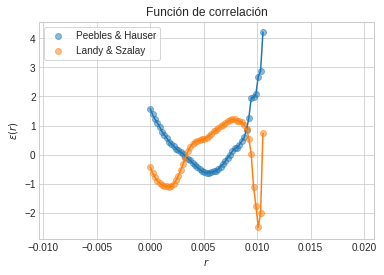

In [21]:
plt.scatter(ex1, ey1, alpha = 0.5, label = 'Peebles & Hauser')
plt.plot(ex1, ey1)
plt.scatter(ex2, ey2, alpha = 0.5, label = 'Landy & Szalay')
plt.plot(ex2, ey2)
#plt.xlim(-0.001, 0.006)
plt.legend(frameon = True, loc = 'best')
plt.xlabel('$r$')
plt.ylabel('$\\varepsilon (r)$')
plt.title('Función de correlación')
plt.show()

### <strong>DEV</strong>

In [22]:
DEV = v[v['type'] == 'DEV']

In [23]:
N = len(DEV)
x_o, y_o, z_o = Observados(N, np.array(DEV['dec']), np.array(DEV['ra']))
x_r, y_r, z_r = Random(N, 25.3, 25.7, 329.95, 330.5)

In [24]:
ex1, ey1 = PH(np.array([x_o, y_o, z_o]).T, np.array([x_r, y_r, z_r]).T, 50)
ex2, ey2 = LS(np.array([x_o, y_o, z_o]).T, np.array([x_r, y_r, z_r]).T, 50)

ex1, ey1, ex2, ey2 = np.array(ex1), np.array(ey1), np.array(ex2), np.array(ey2)

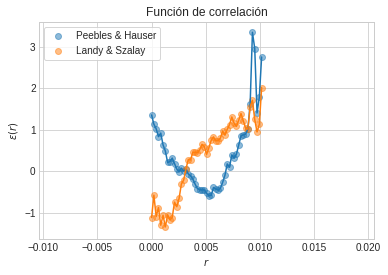

In [25]:
plt.scatter(ex1, ey1, alpha = 0.5, label = 'Peebles & Hauser')
plt.plot(ex1, ey1)
plt.scatter(ex2, ey2, alpha = 0.5, label = 'Landy & Szalay')
plt.plot(ex2, ey2)
#plt.xlim(-0.001, 0.006)
plt.legend(frameon = True, loc = 'best')
plt.xlabel('$r$')
plt.ylabel('$\\varepsilon (r)$')
plt.title('Función de correlación')
plt.show()

### <strong>EXP</strong>

In [26]:
EXP = v[v['type'] == 'EXP']

In [39]:
N = len(EXP)
x_o, y_o, z_o = Observados(N, np.array(EXP['dec']), np.array(EXP['ra']))
x_r, y_r, z_r = Random(N, 25.3, 25.7, 329.95, 330.5)

In [40]:
ex1, ey1 = PH(np.array([x_o, y_o, z_o]).T, np.array([x_r, y_r, z_r]).T, 50)
ex2, ey2 = LS(np.array([x_o, y_o, z_o]).T, np.array([x_r, y_r, z_r]).T, 50)

ex1, ey1, ex2, ey2 = np.array(ex1), np.array(ey1), np.array(ex2), np.array(ey2)

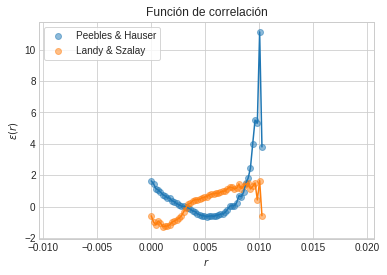

In [41]:
plt.scatter(ex1, ey1, alpha = 0.5, label = 'Peebles & Hauser')
plt.plot(ex1, ey1)
plt.scatter(ex2, ey2, alpha = 0.5, label = 'Landy & Szalay')
plt.plot(ex2, ey2)
#plt.xlim(-0.001, 0.006)
plt.legend(frameon = True, loc = 'best')
plt.xlabel('$r$')
plt.ylabel('$\\varepsilon (r)$')
plt.title('Función de correlación')
plt.show()

### <strong>COMP</strong>

In [30]:
COMP = v[v['type'] == 'COMP']

In [33]:
N = len(COMP)
x_o, y_o, z_o = Observados(N, np.array(COMP['dec']), np.array(COMP['ra']))
x_r, y_r, z_r = Random(N, 25.3, 25.7, 329.95, 330.5)

In [34]:
ex1, ey1 = PH(np.array([x_o, y_o, z_o]).T, np.array([x_r, y_r, z_r]).T, 10)
ex2, ey2 = LS(np.array([x_o, y_o, z_o]).T, np.array([x_r, y_r, z_r]).T, 10)

ex1, ey1, ex2, ey2 = np.array(ex1), np.array(ey1), np.array(ex2), np.array(ey2)

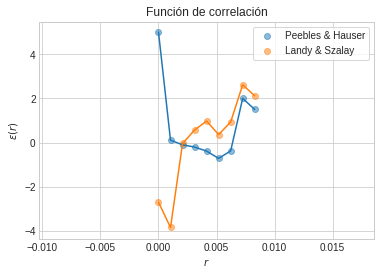

In [35]:
plt.scatter(ex1, ey1, alpha = 0.5, label = 'Peebles & Hauser')
plt.plot(ex1, ey1)
plt.scatter(ex2, ey2, alpha = 0.5, label = 'Landy & Szalay')
plt.plot(ex2, ey2)
#plt.xlim(-0.001, 0.006)
plt.legend(frameon = True, loc = 'best')
plt.xlabel('$r$')
plt.ylabel('$\\varepsilon (r)$')
plt.title('Función de correlación')
plt.show()

### <strong>astroML.correlation</strong>

### <strong>PSF</strong>

In [42]:
import numpy as np
from astroML.correlation import two_point

In [43]:
X = np.array([PSF['dec'], PSF['ra']]).T
bins = np.linspace(0, 1, 30)
corr = two_point(X, bins)

In [44]:
from astroML.correlation import bootstrap_two_point
corr, dcorr = bootstrap_two_point(X, bins, Nbootstrap=5)

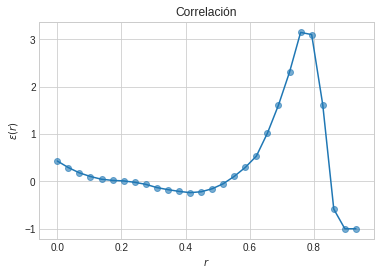

In [45]:
plt.scatter(bins[:len(corr - 1)], corr, alpha = 0.6)
plt.plot(bins[:len(corr - 1)], corr)
plt.xlabel('$r$')
plt.ylabel('$\\varepsilon(r)$')
plt.title('Correlación')
plt.show()

### <strong>REX</strong>

In [46]:
X = np.array([REX['dec'], REX['ra']]).T
corr = two_point(X, bins)

In [47]:
corr, dcorr = bootstrap_two_point(X, bins, Nbootstrap=5)

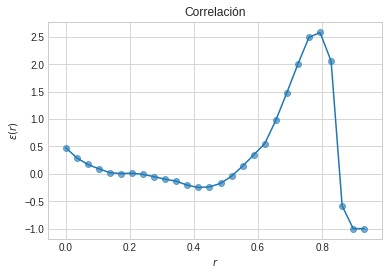

In [48]:
plt.scatter(bins[:len(corr - 1)], corr, alpha = 0.6)
plt.plot(bins[:len(corr - 1)], corr)
plt.xlabel('$r$')
plt.ylabel('$\\varepsilon(r)$')
plt.title('Correlación')
plt.show()

### <strong>DEV</strong>

In [49]:
X = np.array([REX['dec'], REX['ra']]).T
corr = two_point(X, bins)

In [50]:
corr, dcorr = bootstrap_two_point(X, bins, Nbootstrap=5)

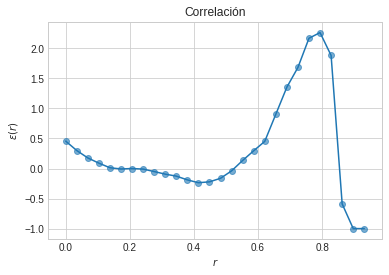

In [51]:
plt.scatter(bins[:len(corr - 1)], corr, alpha = 0.6)
plt.plot(bins[:len(corr - 1)], corr)
plt.xlabel('$r$')
plt.ylabel('$\\varepsilon(r)$')
plt.title('Correlación')
plt.show()

### <strong>EXP</strong>

In [52]:
X = np.array([EXP['dec'], EXP['ra']]).T
corr = two_point(X, bins)

In [53]:
corr, dcorr = bootstrap_two_point(X, bins, Nbootstrap=5)

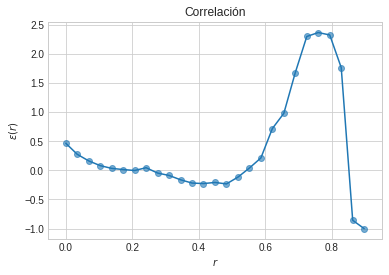

In [54]:
plt.scatter(bins[:len(corr - 1)], corr, alpha = 0.6)
plt.plot(bins[:len(corr - 1)], corr)
plt.xlabel('$r$')
plt.ylabel('$\\varepsilon(r)$')
plt.title('Correlación')
plt.show()

### <strong>COMP</strong>

In [55]:
X = np.array([COMP['dec'], COMP['ra']]).T
corr = two_point(X, bins)

In [56]:
corr, dcorr = bootstrap_two_point(X, bins, Nbootstrap=5)

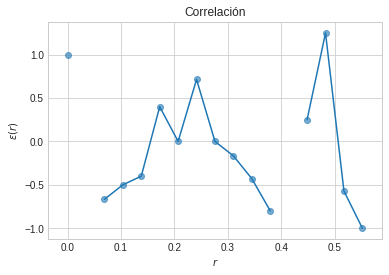

In [57]:
plt.scatter(bins[:len(corr - 1)], corr, alpha = 0.6)
plt.plot(bins[:len(corr - 1)], corr)
plt.xlabel('$r$')
plt.ylabel('$\\varepsilon(r)$')
plt.title('Correlación')
plt.show()

### <strong>Gráfica de las relaciones entre las magnitudes de las galaxias</strong>

Se requirió trabajar con los valores <strong>np.inf</strong> y <strong>NaN</strong>:

In [30]:
graf = ['mag_g', 'mag_r', 'mag_z', 'mag_w1', 'mag_w2', 'mag_w3']
mag = []
for i in range(len(graf)):
    v[graf[i]] = v[graf[i]].astype(float)
    v[graf[i]] = v[graf[i]].replace([-np.inf, np.inf], np.nan)
    v[graf[i]] = v[graf[i]].dropna()
    mag.append(v[graf[i]])
    
mag = np.array(mag)

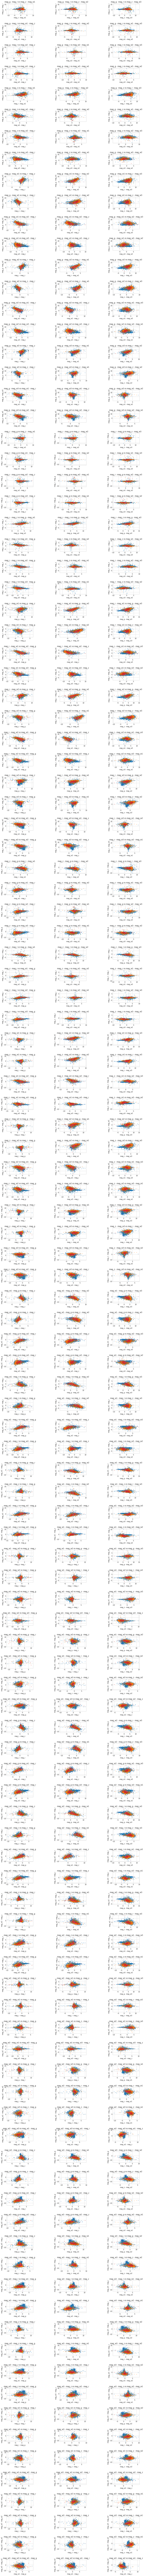

361


In [48]:
tipos = v['type'].unique()

k = 1
fig = plt.figure(figsize=(15,300))
fig.subplots_adjust(hspace=1, wspace=1)

for j in range(len(graf)):
    for l in range(len(graf)):
        for m in range(len(graf)):
            for n in range(len(graf)):
                if(graf[j] != graf[l] and graf[j] != graf[m] and graf[j] != graf[n] and graf[l] != graf[m] and graf[l] != graf[n] and graf[m] != graf[n]):
                    plt.subplot(121, 3, k)
                    for i in range(len(tipos)):
                        plt.scatter(v[graf[m]][v['type'] == tipos[i]] - v[graf[n]][v['type'] == tipos[i]], v[graf[j]][v['type'] == tipos[i]] - v[graf[l]][v['type'] == tipos[i]], s = 2.0, label = '{}'.format(tipos[i]))
                    plt.title('{} - {} vs {} - {}'.format(graf[j], graf[l], graf[m], graf[n]))
                    plt.xlabel('{} - {}'.format(graf[m], graf[n]))
                    plt.ylabel('{} - {}'.format(graf[j], graf[l]))
                    #plt.legend(frameon = True, loc = 'best')
                    k += 1
plt.show()
print(k)